In [1]:
%load_ext autoreload

In [2]:
import os
import torch
import parkinson

import pandas as pd
import numpy as np

from torch import nn
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

from pycatch22 import catch22_all

In [3]:
RDN = 50
N_CLASSES = 2
BATCH_SIZE = 64
N_EPOCHS = 400
PATIENCE = 10
LR = 0.00015
DECAY = 0.0001
SAVE_PATH = '../outputs/2.3_catch22'

# Processamento dos dados

In [4]:
# Lendo os dados dos arquivos.
print('Started file reading...')
parkinson_data = parkinson.utils.data.batch_read('../data/PDs_columns')
control_data = parkinson.utils.data.batch_read('../data/Controls_columns')
prodomal_data = parkinson.utils.data.batch_read('../data/Prodomals_columns')
print('File reading completed.')

# Selecionando o atlas (estratégia de divisão cerebral: Shen_268 ou atlas ou AAL3).
control_atlas_data = parkinson.utils.data.select_atlas_columns(control_data, 'AAL3')
parkinson_atlas_data = parkinson.utils.data.select_atlas_columns(parkinson_data, 'AAL3')
prodomal_atlas_data = parkinson.utils.data.select_atlas_columns(prodomal_data, 'AAL3')

# Transformando os dados selecionados em séries temporais (shape = [n_pacientes, n_canais, n_observações]).
control_ts_data = parkinson.utils.data.df_to_timeseries(control_atlas_data)
parkinson_ts_data = parkinson.utils.data.df_to_timeseries(parkinson_atlas_data)
prodomal_ts_data = parkinson.utils.data.df_to_timeseries(prodomal_atlas_data)

# Misturando pacientes Controle/Parkinson e trocando valores NaN por zero.
X = parkinson.utils.data.concatenate_data(parkinson_ts_data, control_ts_data, prodomal_ts_data)
y = parkinson.utils.data.concatenate_data([1 for _ in range(len(parkinson_data))], [0 for _ in range(len(control_data))], [2 for _ in range(len(prodomal_data))])
X, y = parkinson.utils.data.filter_data(X, y)

Started file reading...


100%|██████████| 188/188 [00:04<00:00, 40.56it/s]


File reading completed.


In [5]:
def extract_catch22_features(X):
    n_samples, n_channels, time = X.shape
    X_feats = np.zeros((n_samples, n_channels, 22))
    for i in range(n_samples):
        for j in range(n_channels):
            feats = catch22_all(X[i, j])['values']
            X_feats[i, j, :] = feats
    return X_feats

print("Extracting catch22 features...")
X = extract_catch22_features(X)
print("Ended extraction.")

mask_valid = ~np.isnan(X).any(axis=(1, 2))
X = X[mask_valid]
y = y[mask_valid]

# Flatten para normalizar (n amostras, n_canais*22)
X_flat = X.reshape(X.shape[0], -1)

# Normalização
scaler = StandardScaler()
X_flat = scaler.fit_transform(X_flat)

# Se quiser manter o shape original (n_amostras, n_canais, 22)
X = X_flat.reshape(X.shape[0], X.shape[1], X.shape[2])

# # Flatten X para (n_samples, n_features)
# X_flat = X.reshape(X.shape[0], -1)

Extracting catch22 features...
Ended extraction.


In [6]:
# Seleção de características usando PCA
n_components = 300  # ajuste conforme necessário
pca = PCA(n_components=n_components, random_state=RDN)
X_pca = pca.fit_transform(X_flat)

In [7]:
# Separando os dados em 80% treino das 2 etapas e 20% teste.
X_train_2etapas, X_test_final, y_train_2etapas, y_test_final = train_test_split(X_pca, y, test_size=0.1, random_state=RDN, stratify=y, shuffle=True)

# Separando os dados da primeira etapa (Control vs Não Saudáveis).
X_1step = X_train_2etapas
y_1step = np.where(y_train_2etapas == 2, 1, y_train_2etapas)
X_1step_trainval, X_1step_test, y_1step_trainval, y_1step_test = train_test_split(X_1step, y_1step, test_size=0.2, random_state=RDN, stratify=y_train_2etapas, shuffle=True)
X_1step_train, X_1step_val, y_1step_train, y_1step_val = train_test_split(X_1step_trainval, y_1step_trainval, test_size=1/8, random_state=RDN, stratify=y_1step_trainval, shuffle=True)

# Separando os dados da segunda etapa (Parkinson vs Prodomals).
X_2step = X_train_2etapas[y_train_2etapas != 0]
y_2step = y_train_2etapas[y_train_2etapas != 0]
y_2step = np.where(y_2step == 2, 0, y_2step)
X_2step_trainval, X_2step_test, y_2step_trainval, y_2step_test = train_test_split(X_2step, y_2step, test_size=0.2, random_state=RDN, stratify=y_2step, shuffle=True)
X_2step_train, X_2step_val, y_2step_train, y_2step_val = train_test_split(X_2step_trainval, y_2step_trainval, test_size=1/8, random_state=RDN, stratify=y_2step_trainval, shuffle=True)

In [8]:
# from imblearn.under_sampling import RandomUnderSampler
# from collections import Counter

# n_samples_class_0 = Counter(y_1step_train)[0]
# sampling_strategy_dict = {
#     0: n_samples_class_0,  # Manter todas as amostras da classe 0
#     1: int(n_samples_class_0 * 3)   # Reduzir a classe 1 para ter o mesmo número de amostras da classe 0
# }

# rus = RandomUnderSampler(sampling_strategy=sampling_strategy_dict, random_state=42)
# X_pca_resampled, y_resampled = rus.fit_resample(X_1step_train, y_1step_train)

In [9]:
# Criando DataLoader
test_final_loader = parkinson.utils.data.get_torch_dataloader(X_test_final, y_test_final, batch_size=BATCH_SIZE)

train_1step_loader = parkinson.utils.data.get_torch_dataloader(X_1step_train, y_1step_train, batch_size=BATCH_SIZE)
val_1step_loader = parkinson.utils.data.get_torch_dataloader(X_1step_val, y_1step_val, batch_size=BATCH_SIZE)
test_1step_loader = parkinson.utils.data.get_torch_dataloader(X_1step_test, y_1step_test, batch_size=BATCH_SIZE)

train_2step_loader = parkinson.utils.data.get_torch_dataloader(X_2step_train, y_2step_train, batch_size=BATCH_SIZE)
val_2step_loader = parkinson.utils.data.get_torch_dataloader(X_2step_val, y_2step_val, batch_size=BATCH_SIZE)
test_2step_loader = parkinson.utils.data.get_torch_dataloader(X_2step_test, y_2step_test, batch_size=BATCH_SIZE)

# Treinamento Control vs Não Saudáveis (1 step)

In [10]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# model = parkinson.NetworkModels.customFCN(X_1step_train.shape[1], N_CLASSES)
model = parkinson.NetworkModels.customMLP(input_dim=n_components, hidden_dim=16, output_dim=N_CLASSES)

model.train()
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_1step_train), y=y_1step_train)
class_weights = torch.tensor(class_weights, dtype=torch.float).to(device)
criterion = nn.CrossEntropyLoss()

out1 = parkinson.utils.train.train(model, train_1step_loader, val_1step_loader, device, N_EPOCHS, PATIENCE, LR, "../weights/2.3_catch22/1step", DECAY)

metrics1 = parkinson.utils.train.evaluate(model, test_1step_loader, device, "../weights/2.3_catch22/1step")

train-loss: 0.1508  train-acc: 0.9802 | val-loss: 0.6908  val-acc: 0.6757:  32%|███▏      | 127/400 [01:05<02:20,  1.94it/s]

Early stopping at epoch 128


# Treinamento Parkinson vs Prodomals (2 step)

In [11]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# model = parkinson.NetworkModels.customFCN(X_2step_train.shape[1], N_CLASSES)
model = parkinson.NetworkModels.customMLP(input_dim=X_1step_train.shape[1], hidden_dim=16, output_dim=N_CLASSES)

model.train()
criterion = nn.CrossEntropyLoss()

out2 = parkinson.utils.train.train(model, train_2step_loader, val_2step_loader, device, N_EPOCHS, PATIENCE, LR, "../weights/2.3_catch22/2step", DECAY)

metrics2 = parkinson.utils.train.evaluate(model, test_2step_loader, device, "../weights/2.3_catch22/2step")

train-loss: 0.4968  train-acc: 0.7547 | val-loss: 0.7290  val-acc: 0.5484:   9%|▉         | 37/400 [00:19<03:14,  1.87it/s]

Early stopping at epoch 38


# Análise dos resultados

## 1 Step

 Acurácia       F1  Precisão   Recall
 0.657534 0.672243  0.688096 0.657534


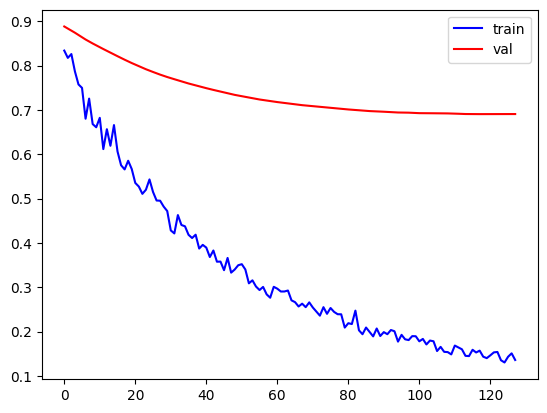

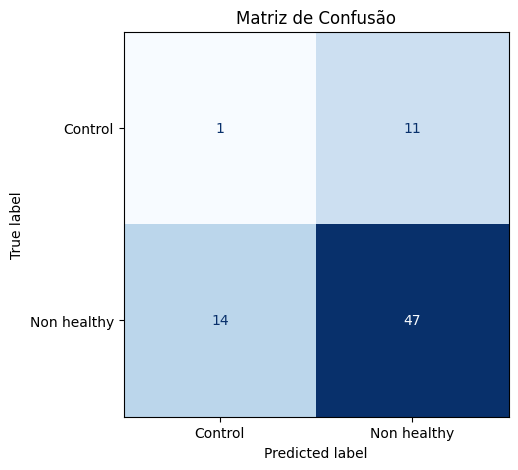

In [12]:
# Criando e plotando os resultados.
parkinson.utils.results.metrics_to_dataframe(metrics1)
fig_loss = parkinson.utils.results.plot_losses(out1['train_loss'],out1['val_loss'])
fig_loss.show()
fig_cf = parkinson.utils.results.plot_confusion_matrix(metrics1['preds'], metrics1['labels'], class_names=['Control','Non healthy'])
fig_cf.show()

# Salvando as figuras.
fig_loss.savefig(f"{SAVE_PATH}/1step/loss_curve.png", bbox_inches='tight')
fig_cf.savefig(f"{SAVE_PATH}/1step/confusion_matrix.png", bbox_inches='tight')

## 2 Step

 Acurácia       F1  Precisão   Recall
 0.442623 0.442623  0.442623 0.442623


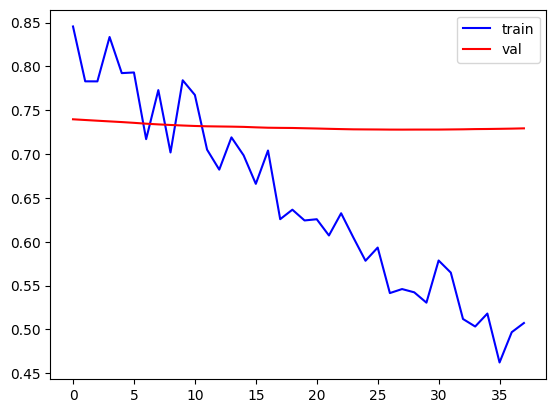

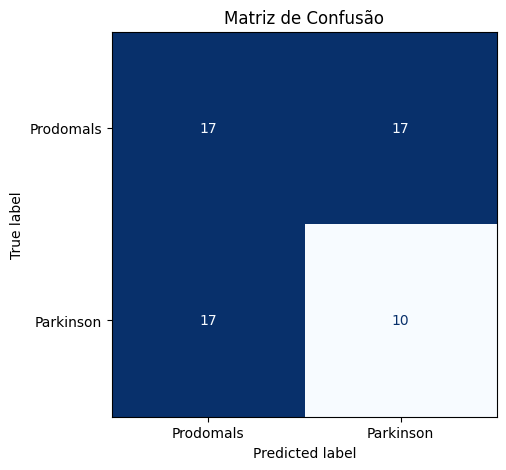

In [13]:
# Criando e plotando os resultados.
parkinson.utils.results.metrics_to_dataframe(metrics2)
fig_loss = parkinson.utils.results.plot_losses(out2['train_loss'],out2['val_loss'])
fig_loss.show()
fig_cf = parkinson.utils.results.plot_confusion_matrix(metrics2['preds'], metrics2['labels'], class_names=['Prodomals','Parkinson'])
fig_cf.show()

# Salvando as figuras.
fig_loss.savefig(f"{SAVE_PATH}/2step/loss_curve.png", bbox_inches='tight')
fig_cf.savefig(f"{SAVE_PATH}/2step/confusion_matrix.png", bbox_inches='tight')

# Treinamento Modelo Final

In [14]:
# model1 = parkinson.NetworkModels.customFCN(X_1step_train.shape[1], N_CLASSES).to(device)
model1 = parkinson.NetworkModels.customMLP(input_dim=X_1step_train.shape[1], hidden_dim=16, output_dim=N_CLASSES).to(device)
model1.load_state_dict(torch.load("../weights/2.3_catch22/1step/best_model.pth", map_location=device))

# model2 = parkinson.NetworkModels.customFCN(X_2step_train.shape[1], N_CLASSES).to(device)
model2 = parkinson.NetworkModels.customMLP(input_dim=X_1step_train.shape[1], hidden_dim=16, output_dim=N_CLASSES).to(device)
model2.load_state_dict(torch.load("../weights/2.3_catch22/2step/best_model.pth", map_location=device))

<All keys matched successfully>

In [15]:
all_preds = []
all_true = []

model1.eval()
model2.eval()
with torch.no_grad():
    for X_batch, y_batch in test_final_loader:
        for i in range(X_batch.shape[0]):
            x = X_batch[i].unsqueeze(0).to(device)
            y_true = y_batch[i].item()
            all_true.append(y_true)
            output1 = model1(x)
            pred1 = output1.argmax(dim=1).item()
            if pred1 == 0:
                all_preds.append(0)  # Control
            else:
                output2 = model2(x)
                pred2 = output2.argmax(dim=1).item()
                if pred2 == 1:
                    all_preds.append(1)  # Parkinson
                else:
                    all_preds.append(2)  # Prodomal

   Acurácia        F1  Precisão    Recall
0  0.341463  0.349463  0.364448  0.341463


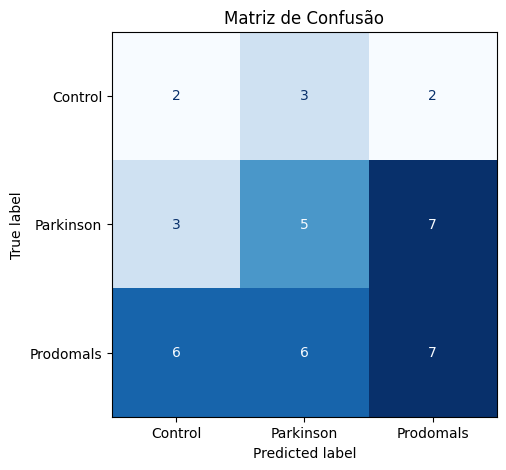

In [16]:
# Calculando métricas gerais para o modelo final (3 classes)
df_metrics = pd.DataFrame({
    'Acurácia': [accuracy_score(all_true, all_preds)],
    'F1': [f1_score(all_true, all_preds, average='weighted')],
    'Precisão': [precision_score(all_true, all_preds, average='weighted')],
    'Recall': [recall_score(all_true, all_preds, average='weighted')]
})
print(df_metrics)

# Criando e plotando os resultados.
fig_cf = parkinson.utils.results.plot_confusion_matrix(all_preds, all_true, class_names=['Control','Parkinson', 'Prodomals'])
fig_cf.show()

# Salvando as figuras.
fig_cf.savefig(f"{SAVE_PATH}/confusion_matrix.png", bbox_inches='tight')